Version 2.0:

1.   Usa 'duration of stay'. en lugar de calcularla con DOA y DOE.

2.   Utiliza unicamente el ultimo registro del paciente segun su fecha de admision

3. Al eliminar registros duplicados, no hace GroupFold para train/test

4. Eliminé la columna bnp por alta cantidad de nulls

Version 3.0:

1. Elimine las columnas creadas en ingenieria de variables. Cuando las quité, mejoraron las metricas, por lo que las variables introducian ruido al modelo

2. Elimine los registros de 'duration of stay' mayores a 15 días. Mejoraron mucho mas las metricas.

Version 4.0:

1. Cambie el clasificador, en lugar de definir el long stay con un percentil,  defini que long stay es > de 7 dìas. Mejoraron las metricas y a nivel operativo conviene esa cantidad de dias en lugar de un percentil

Version 5.0:

1. Use KNN en lugar de la media para imputar los nulls

Version 6.0:

1. Probe Redes neuronales simples al final

In [ ]:
# ============================================================
# IMPORTACIÓN DE LIBRERÍAS
# ============================================================

# IMPORTS GENERALES
import sys, json, os, math, random, re, warnings, chardet
from pathlib import Path

# CIENCIA DE DATOS / NUMPY / PANDAS
import numpy as np
import pandas as pd

# VISUALIZACIÓN
import matplotlib.pyplot as plt
from IPython.display import display

# ENTORNO KAGGLE
import kagglehub

# SCIKIT-LEARN: MODELADO Y PREPROCESAMIENTO
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import FunctionTransformer,StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.impute import SimpleImputer

# GRADIENT BOOSTING: XGBoost y LightGBM
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

In [ ]:
# ============================================================
# CONFIGURACIÓN INICIAL DEL ENTORNO Y PARÁMETROS DEL MODELO
# ============================================================

# Ignorar advertencias para no ensuciar la salida en Colab
warnings.filterwarnings("ignore")

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Parámetros específicos del problema
LONG_STAY_THRESHOLD_DAYS = 7   # 7 dias para determinar LONG STAY

# Nombres de columnas relevantes en el dataset
GROUP_COL = "mrd_no"      # Nro de registro del paciente
DATE_ADM = "d_o_a"        # Fecha de ingreso
DATE_DIS = "d_o_d"        # Fecha de alta
TARGET_REG = "duration_of_stay"   # Variable continua a predecir: tiempo de estadía (en días)
TARGET_BIN = "long_stay"  # Variable binaria a predecir: estancia prolongada (Sí/No)

# Cargar el dataset desde Kaggle
path = kagglehub.dataset_download("ashishsahani/hospital-admissions-data")
file_path = os.path.join(path, "HDHI Admission data.csv")
with open(file_path, "rb") as f:
    raw_data = f.read(100000)
    result = chardet.detect(raw_data)
df = pd.read_csv(file_path, encoding=result["encoding"])

# Inspección inicial del dataset
print(df.shape)
df.head()

Using Colab cache for faster access to the 'hospital-admissions-data' dataset.
(15757, 56)


,SNO,MRD No.,D.O.A,D.O.D,AGE,GENDER,RURAL,TYPE OF ADMISSION-EMERGENCY/OPD,month year,DURATION OF STAY,...,CONGENITAL,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
1,2,234696,4/1/2017,4/5/2017,65,M,R,E,Apr-17,5,...,0,0,0,0,0,0,0,0,0,0
2,3,234882,4/1/2017,4/3/2017,53,M,U,E,Apr-17,3,...,0,0,0,0,0,0,0,0,0,0
3,4,234635,4/1/2017,4/8/2017,67,F,U,E,Apr-17,8,...,0,0,0,0,0,0,0,0,0,0
4,5,234486,4/1/2017,4/23/2017,60,F,U,E,Apr-17,23,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# ============================================================
# FUNCIONES AUXILIARES
# ============================================================

def normalizar_cols(cols):
    """
    Normaliza nombres de columnas a formato snake_case:
    - Elimina espacios iniciales/finales.
    - Elimina caracteres invisibles (ej. \u200b).
    - Sustituye caracteres no alfanuméricos por "_".
    - Colapsa múltiples "_" en uno solo.
    - Pasa todo a minúsculas.
    Ejemplo:
        "D.O.A" -> "d_o_a"
    """

    out = []
    for c in cols:
        c = c.strip()
        c = c.replace("\u200b","")
        c = re.sub(r"[^0-9A-Za-z]+", "_", c)
        c = re.sub(r"_+", "_", c).strip("_").lower()
        out.append(c)
    return out

def corregir_fechas(df):
    # 1) Respaldos: guardamos copias en texto de las columnas originales
    # para no perder la información antes de hacer conversiones.
    df["d_o_a_raw"] = df[DATE_ADM].astype(str)
    df["d_o_d_raw"] = df[DATE_DIS].astype(str)

    # 2) Normalización de la columna "month_year" (ej: "Apr-17", "Apr 2017")
    # Primero intenta parsear con formato fijo "%b-%y".
    mY = pd.to_datetime(df["month_year"], errors="coerce", format="%b-%y")

    # Para los que fallan, intenta de nuevo dejando que Pandas infiera el formato.
    mY = mY.fillna(pd.to_datetime(df["month_year"], errors="coerce", infer_datetime_format=True))

    # Contamos cuántas filas quedaron sin parsear correctamente.
    bad_mY = mY.isna().sum()
    if bad_mY:
        print(f"[Diag] month_year no parseable en {bad_mY} filas")

    # 3) Corrección de fechas de admisión (D.O.A)
    # Generamos dos interpretaciones posibles de la fecha:
    #   doa_dfirst - dayfirst=True (formato D/M/Y)
    #   doa_mfirst - dayfirst=False (formato M/D/Y)
    doa_dfirst = pd.to_datetime(df["d_o_a_raw"], errors="coerce", dayfirst=True)
    doa_mfirst = pd.to_datetime(df["d_o_a_raw"], errors="coerce", dayfirst=False)

    # Comprobamos cuál coincide en mes y año con "month_year".
    match_dfirst = (doa_dfirst.dt.month == mY.dt.month) & (doa_dfirst.dt.year == mY.dt.year)
    match_mfirst = (doa_mfirst.dt.month == mY.dt.month) & (doa_mfirst.dt.year == mY.dt.year)

    # Seleccionamos:
    # - Si dayfirst coincide -> usamos esa fecha.
    # - Si no, pero monthfirst coincide -> usamos esa.
    # - En cualquier otro caso -> usamos la interpretación dayfirst por defecto.
    doa_fixed = doa_dfirst.where(match_dfirst, doa_mfirst.where(match_mfirst, doa_dfirst))
    df["d_o_a"] = doa_fixed

    # 4) Corrección de fechas de alta (D.O.D)
    # Igual que antes, generamos dos interpretaciones (dayfirst y monthfirst).
    dod_dfirst = pd.to_datetime(df["d_o_d_raw"], errors="coerce", dayfirst=True)
    dod_mfirst = pd.to_datetime(df["d_o_d_raw"], errors="coerce", dayfirst=False)

    # Validamos que la fecha de alta sea >= fecha de ingreso.
    cand1_valid = dod_dfirst >= df[DATE_ADM]
    cand2_valid = dod_mfirst >= df[DATE_ADM]

    # Calculamos la diferencia absoluta de días con respecto a la fecha de ingreso.
    # Esto ayuda a elegir la fecha más lógica si ambas son válidas.
    diff1 = (dod_dfirst - df[DATE_ADM]).abs()
    diff2 = (dod_mfirst - df[DATE_ADM]).abs()

    # Regla de elección:
    # - Usamos monthfirst si es válido y:
    #   a) dayfirst no es válido, o
    #   b) la diferencia con la fecha de ingreso es menor.
    choose2 = cand2_valid & (~cand1_valid | (diff2 < diff1))

    # Construimos la fecha final de alta:
    # - Si corresponde elegir monthfirst -> la usamos.
    # - Si hay nulos, completamos primero con monthfirst y luego con dayfirst.
    dod_fixed = dod_dfirst.mask(choose2, dod_mfirst)
    dod_fixed = dod_fixed.fillna(dod_mfirst).fillna(dod_dfirst)
    df[DATE_DIS] = dod_fixed

    return df

In [ ]:
#Eliminamos los pacientes con alta contra indicacion medica, ya que ensucian el LOS

df = df[df['OUTCOME'] != 'DAMA']

In [ ]:
# ============================================================
# PREPROCESAMIENTO INICIAL DEL DATASET
# ============================================================

# 1) Normalización de nombres de columnas
df.columns = normalizar_cols(df.columns)

# 2) Inspección del dataset tras normalización
print("Nulos por columna:")
print(df.isnull().sum().sort_values(ascending = False))

# 3) Parseo de fechas de admisión y alta
df = corregir_fechas(df)

# 4) Eliminar casos en que la fecha de alta < fecha de ingreso
mask_bad = df[DATE_DIS] < df[DATE_ADM]
print("Registros con alta < ingreso:", mask_bad.sum())
df = df[~mask_bad].copy()

print("Dataset limpio:", df.shape)

Nulos por columna:
bnp                                8050
ef                                 1431
glucose                             632
platelets                           243
tlc                                 238
hb                                  218
creatinine                          211
urea                                204
type_of_admission_emergency_opd       0
rural                                 0
gender                                0
age                                   0
d_o_d                                 0
month_year                            0
duration_of_intensive_unit_stay       0
duration_of_stay                      0
htn                                   0
dm                                    0
alcohol                               0
smoking                               0
outcome                               0
sno                                   0
d_o_a                                 0
mrd_no                                0
prior_cmp            

In [ ]:
# ============================================================
# Pre procesamiento de datos
# ============================================================

# Eliminacion de registros de estancia mayores de 15 dias
df = df[df['duration_of_stay'] <= 15]

# Eliminacion de la columna 'bnp' por alta cantidad de nulls
df = df.drop(columns=['bnp'])

In [ ]:
# ============================================================
# Conservar solo la última admisión por paciente
# ============================================================

# Cantidad inicial de registros
print("Cantidad inicial de registros:", len(df))

# Convertir a datetime si aún no lo está

# Ordenar por fecha de admisión
df = df.sort_values(by=["mrd_no", "d_o_a_raw"])

# Conservar solo la última admisión por paciente
df = df.drop_duplicates(subset=["mrd_no"], keep="last")

# Cantidad después del tratamiento
print("Cantidad después de conservar última admisión:", len(df))


Cantidad inicial de registros: 14166
Cantidad después de conservar última admisión: 11146


In [ ]:
# ============================================================
# DEFINICIÓN DEL TARGET Y SPLIT TRAIN/TEST
# ============================================================

# Etiqueta TARGET REG

df['TARGET_REG'] = df['duration_of_stay']

#  Etiqueta TARGET BIN de long stay > 5 dias

df["TARGET_BIN"] = (df["duration_of_stay"] > LONG_STAY_THRESHOLD_DAYS).astype(int)


In [ ]:
# ============================================================
# BASELINES: MÉTRICAS INICIALES PARA REGRESIÓN Y CLASIFICACIÓN
# ============================================================
# Funciones auxiliares y baselines para comparar con los modelos avanzados

def recall_at_topk(y_true, y_score, k):
    """
    Calcula el recall en el top-k:
    - Ordena instancias por score descendente.
    - Toma las k con mayor score.
    - Mide qué proporción de verdaderos positivos
      quedaron dentro de esas k.
    """
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    k = int(k)
    if k <= 0:
        return 0.0

    top_idx = np.argsort(-y_score)[:k]  # índices ordenados
    tp_in_topk = y_true[top_idx].sum()  # verdaderos positivos en top-k
    total_pos = y_true.sum()
    return float(tp_in_topk / total_pos) if total_pos > 0 else 0.0



# ------------------------------------------------------------
# Función de evaluación (para reusar en todos los modelos)
# ------------------------------------------------------------

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calcula el MAPE (Mean Absolute Percentage Error).
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def eval_regressor(pipeline, X_te, y_te):
    """
    Evalúa un regresor y devuelve métricas MAE, RMSE y MAPE.
    """
    pred = pipeline.predict(X_te)
    mae = mean_absolute_error(y_te, pred)
    mse = mean_squared_error(y_te, pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_te, pred)
    return {"mae": float(mae), "rmse": float(rmse), "mape": float(mape)}, pred


# ------------------------------------------------------------
# Baseline de regresión
# ------------------------------------------------------------

def baseline_regresion(train, test):
    global_median = float(train[TARGET_REG].median())
    y_pred = pd.Series(global_median, index=test.index)

    mae  = mean_absolute_error(test[TARGET_REG], y_pred)
    rmse = float(np.sqrt(mean_squared_error(test[TARGET_REG], y_pred)))
    mape = mean_absolute_percentage_error(test[TARGET_REG], y_pred)
    return {"mae": float(mae), "rmse": rmse, "mape": float(mape)}, y_pred


# ------------------------------------------------------------
# Baseline de clasificación
# ------------------------------------------------------------

def baseline_clasificacion(train, test):
    train = train.copy()
    train[TARGET_BIN] = (train[TARGET_REG] > LONG_STAY_THRESHOLD_DAYS).astype(int)

    global_p = float(train[TARGET_BIN].mean())
    y_score = pd.Series(global_p, index=test.index)

    ap = float(average_precision_score(test[TARGET_BIN], y_score))
    roc = float(roc_auc_score(test[TARGET_BIN], y_score))
    k20 = max(1, int(0.2 * len(test)))
    rec_at_20 = float(recall_at_topk(test[TARGET_BIN], y_score, k=k20))

    return {"ap": ap, "roc_auc": roc, "recall_at_20": rec_at_20}, y_score


In [ ]:
# ============================================================
# PIPELINE DE PREPROCESAMIENTO
# ============================================================


num_features = [
    'age','smoking','alcohol','dm','htn','cad','prior_cmp','ckd','hb','glucose','creatinine',
    'ef','raised_cardiac_enzymes','severe_anaemia','anaemia','stable_angina',
    'acs','stemi','atypical_chest_pain','heart_failure','hfref','hfnef','valvular','chb','sss','aki',
    'cva_infract','cva_bleed','af','vt','psvt','congenital','uti','neuro_cardiogenic_syncope','orthostatic',
    'infective_endocarditis','dvt','cardiogenic_shock','shock','pulmonary_embolism',
    'tlc','platelets','urea'
]

cat_features = [
    'gender','rural','type_of_admission_emergency_opd'
]


TEXTOS_EN_NUMEROS = {"EMPTY", "", "NA", "N/A", "None", "null", "Null", "NULL", "-"}

def to_numeric_matrix(X):
    Xdf = pd.DataFrame(X)
    Xdf = Xdf.replace(list(TEXTOS_EN_NUMEROS), np.nan)
    for c in Xdf.columns:
        Xdf[c] = pd.to_numeric(Xdf[c], errors="coerce")
    return Xdf.values


num_transformer = Pipeline(steps=[
    ("to_numeric", FunctionTransformer(to_numeric_matrix, feature_names_out="one-to-one")),
    ("knn_imp", KNNImputer(n_neighbors=10, weights="distance", metric="nan_euclidean")),
    ("scaler", StandardScaler())
])

# Indicadores de missing (equivalente a add_indicator=True), en paralelo:
num_missing_flags = Pipeline(steps=[
    ("to_numeric", FunctionTransformer(to_numeric_matrix, feature_names_out="one-to-one")),
    ("miss_ind", MissingIndicator(features="all"))
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# ------------------------------------------------------------
# 3) ColumnTransformer
#    Une ambos pipelines en un solo preprocesador.
# ------------------------------------------------------------

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("num_miss", num_missing_flags, num_features),  # agrega columnas binarias de faltantes
        ("cat", cat_transformer, cat_features),
    ],
    remainder="drop"
)


In [ ]:
# ============================================================
# EVALUACIÓN 5-FOLD (KFold) — BASELINES + MODELOS (sin GroupKFold)
# ------------------------------------------------------------
# Se evalúan baselines y modelos entrenando y testeando por fold.
# ============================================================

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, average_precision_score, roc_auc_score

# --- Cross-validation 5-fold estándar ---
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Acumuladores de métricas (baselines)
bl_reg_mae, bl_reg_rmse = [], []
bl_cls_ap, bl_cls_auc, bl_cls_recall20 = [], [], []

# Acumuladores de métricas (modelos)
mdl_reg_mae, mdl_reg_rmse = [], []
mdl_cls_ap, mdl_cls_auc, mdl_cls_recall20 = [], [], []

for tr_idx, te_idx in kf.split(df):
    tr_df = df.iloc[tr_idx].copy()
    te_df = df.iloc[te_idx].copy()

    # ---------- Etiquetado TARGET_BIN por fold (usando SOLO train del fold) ----------

    tr_df[TARGET_BIN] = (tr_df['TARGET_REG'] > LONG_STAY_THRESHOLD_DAYS).astype(int)
    te_df[TARGET_BIN] = (te_df['TARGET_REG'] > LONG_STAY_THRESHOLD_DAYS).astype(int)

    # ---------- Baselines ----------
    # REGRESIÓN
    reg_metrics, reg_pred = baseline_regresion(tr_df, te_df)
    bl_reg_mae.append(reg_metrics["mae"])
    bl_reg_rmse.append(reg_metrics["rmse"])

    # CLASIFICACIÓN
    cls_metrics, cls_score = baseline_clasificacion(tr_df, te_df)
    bl_cls_ap.append(cls_metrics["ap"])
    bl_cls_auc.append(cls_metrics["roc_auc"])
    bl_cls_recall20.append(cls_metrics["recall_at_20"])

    # ---------- MODELOS ----------
    # --- REGRESIÓN (ElasticNet) ---
    X_tr_reg = tr_df.drop(['TARGET_REG', TARGET_BIN], axis=1)
    y_tr_reg = tr_df['TARGET_REG']
    X_te_reg = te_df.drop(['TARGET_REG', TARGET_BIN], axis=1)
    y_te_reg = te_df['TARGET_REG']

    reg_pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
    ])
    reg_pipe.fit(X_tr_reg, y_tr_reg)
    y_pred_reg = reg_pipe.predict(X_te_reg)

    mdl_reg_mae.append(mean_absolute_error(y_te_reg, y_pred_reg))
    mdl_reg_rmse.append(np.sqrt(mean_squared_error(y_te_reg, y_pred_reg)))

    # --- CLASIFICACIÓN (LogisticRegression) ---
    X_tr_cls = tr_df.drop(['TARGET_REG', TARGET_BIN], axis=1)
    y_tr_cls = tr_df[TARGET_BIN].astype(int)
    X_te_cls = te_df.drop(['TARGET_REG', TARGET_BIN], axis=1)
    y_te_cls = te_df[TARGET_BIN].astype(int)

    cls_pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=1000))
    ])
    cls_pipe.fit(X_tr_cls, y_tr_cls)
    y_proba = cls_pipe.predict_proba(X_te_cls)[:, 1]

    mdl_cls_ap.append(average_precision_score(y_te_cls, y_proba))
    mdl_cls_auc.append(roc_auc_score(y_te_cls, y_proba))
    k20 = max(1, int(0.2 * len(y_te_cls)))
    mdl_cls_recall20.append(recall_at_topk(y_te_cls, y_proba, k=k20))

# ---------- Resultados promedio ----------
print("=== Baselines (promedio 5-fold) ===")
print("Reg — MAE:", np.mean(bl_reg_mae), "RMSE:", np.mean(bl_reg_rmse))
print("Cls — AP:", np.mean(bl_cls_ap), "ROC-AUC:", np.mean(bl_cls_auc), "Recall@20%:", np.mean(bl_cls_recall20))

print("\n=== Modelos (promedio 5-fold) ===")
print("Reg — MAE:", np.mean(mdl_reg_mae), "RMSE:", np.mean(mdl_reg_rmse))
print("Cls — AP:", np.mean(mdl_cls_ap), "ROC-AUC:", np.mean(mdl_cls_auc), "Recall@20%:", np.mean(mdl_cls_recall20))


=== Baselines (promedio 5-fold) ===
Reg — MAE: 2.4876219905968413 RMSE: 3.225592634117961
Cls — AP: 0.2451111017227054 ROC-AUC: 0.5 Recall@20%: 0.19056397306397307

=== Modelos (promedio 5-fold) ===
Reg — MAE: 2.517515239399164 RMSE: 3.1347680720155786
Cls — AP: 0.4519630214075942 ROC-AUC: 0.7409816622371224 Recall@20%: 0.3943524531024531


In [ ]:
def bad_num_cols(df, num_cols):
    bad = {}
    for c in num_cols:
        if c in df.columns:
            s = df[c]
            # dtypes objeto o mezclados
            if s.dtype == "object":
                bad[c] = s.value_counts(dropna=False).head(5).to_dict()
            else:
                # intenta convertir por si hay strings camuflados
                sc = pd.to_numeric(s, errors="coerce")
                if sc.isna().sum() > s.isna().sum():  # hubo strings no numéricos
                    bad[c] = s[~s.astype(str).str.match(r"^-?\d+(\.\d+)?$", na=True)].head(5).tolist()
    return bad

bad = bad_num_cols(X_tr_reg, num_features)
print("Columnas numéricas con strings:", bad)  # verás 'EMPTY', '', 'NA', etc.

Columnas numéricas con strings: {'hb': {'13.1': 175, '12.9': 175, '13.3': 174, '13.9': 167, '12.1': 166}, 'glucose': {nan: 429, '110': 154, '98': 141, '96': 124, '100': 121}, 'creatinine': {'0.8': 900, '0.7': 836, '0.9': 764, '0.6': 576, '1': 547}, 'ef': {'60': 2609, nan: 902, '35': 494, '30': 454, '45': 408}, 'tlc': {nan: 178, '7.9': 129, '7.7': 127, '9.4': 125, '8.4': 117}, 'platelets': {nan: 178, '150': 114, '140': 60, '210': 59, '222': 55}, 'urea': {'27': 274, '26': 273, '22': 272, '25': 261, '24': 261}}


ElasticNet (test): {'mae': 2.1175321685211714, 'rmse': 2.745288843158515, 'mape': 59.4212146417502}
ElasticNet (test): {'mae': 2.1175321685211714, 'rmse': 2.745288843158515, 'mape': 59.4212146417502}
XGBRegressor (test): {'mae': 2.098383665084839, 'rmse': 2.698002630997401, 'mape': 58.745454730052096}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1941
[LightGBM] [Info] Number of data points in the train set: 8916, number of used features: 55
[LightGBM] [Info] Start training from score 5.625280
LGBMRegressor (test): {'mae': 2.0610471920882376, 'rmse': 2.6773416191519495, 'mape': 56.38042948804613}
NeuralNet (test): {'mae': 2.065408706665039, 'rmse': 2.709032340199238, 'mape': 55.64737956780106}


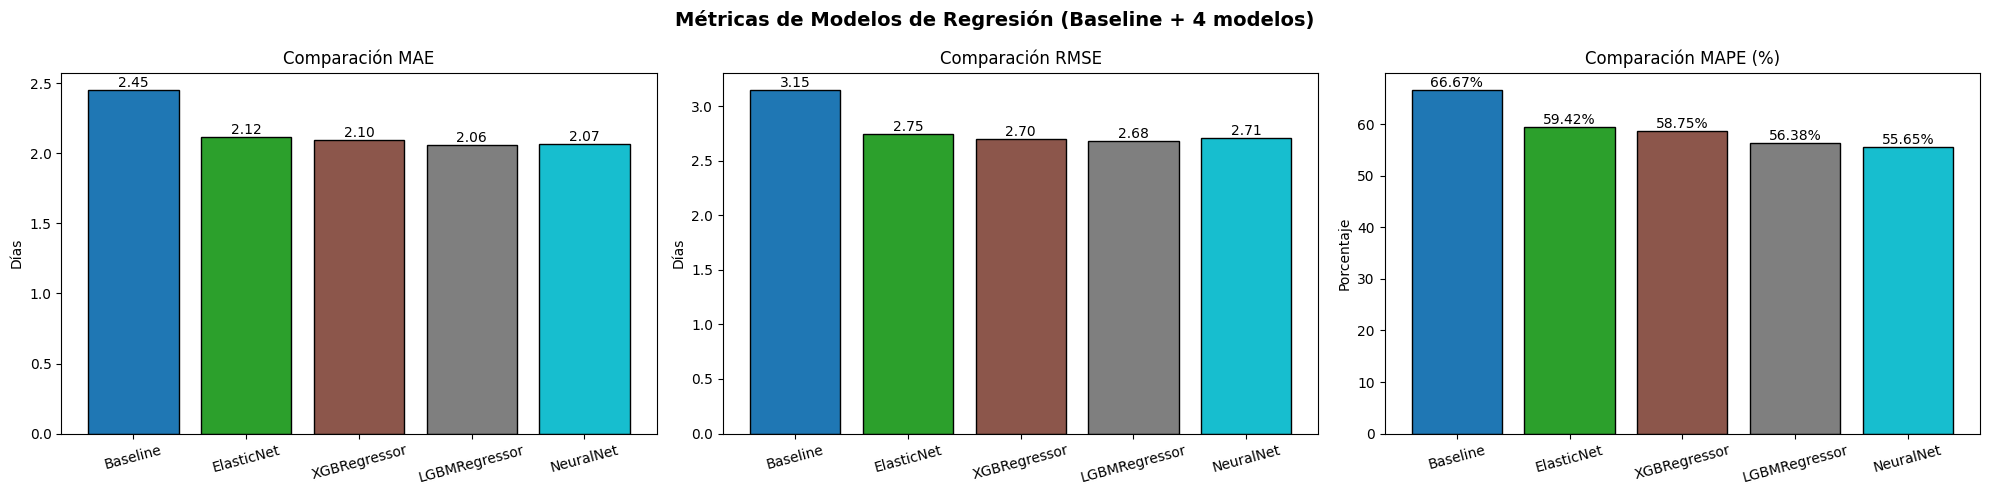

In [ ]:
# ============================================================
# MODELADO (SPLIT FINAL - HOLDOUT TEST): REGRESIÓN (LOS en días)
# ============================================================
# Se prueban distintos algoritmos de regresión con el pipeline
# de preprocesamiento definido previamente.
# - ElasticNet con búsqueda de hiperparámetros
# - XGBoost Regressor
# - LightGBM Regressor

# ------------------------------------------------------------
# 1) Separación de features (X) y target (y)
# ------------------------------------------------------------

# Hold-out final (un solo fold) para las comparativas siguientes
tr_idx, te_idx = next(kf.split(df, groups=df[GROUP_COL]))
df_train = df.iloc[tr_idx].copy()
df_test  = df.iloc[te_idx].copy()

# Etiquetado de TARGET_BIN con umbrales aprendidos en el conjunto de entrenamiento (TRAIN)
# Etiquetado de TARGET_BIN con umbral fijo


df_train[TARGET_BIN] = (df_train[TARGET_REG] > LONG_STAY_THRESHOLD_DAYS).astype(int)
df_test[TARGET_BIN]  = (df_test[TARGET_REG]  > LONG_STAY_THRESHOLD_DAYS).astype(int)


# Baselines para las comparativas que siguen
base_reg_metrics, _ = baseline_regresion(df_train, df_test)
base_cls_metrics, base_cls_scores = baseline_clasificacion(df_train, df_test)

X_train = df_train.drop([TARGET_REG, TARGET_BIN], axis=1)
y_train_reg = df_train[TARGET_REG]
X_test  = df_test.drop([TARGET_REG, TARGET_BIN], axis=1)
y_test_reg = df_test[TARGET_REG]
groups = df_train[GROUP_COL]

# ------------------------------------------------------------
# 2) ElasticNet con GridSearchCV
# ------------------------------------------------------------

enet = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

# Hiperparámetros:

# versión reducida para acelerar entrenamiento
'''
param_enet = {
    "model__alpha": [0.1, 1.0],   # fuerza de regularización
    "model__l1_ratio": [0.5]      # mezcla L1/L2
}
'''

# Versión más compleja (más lenta):
param_enet = {
    "model__alpha": [0.01, 0.1, 1.0],
    "model__l1_ratio": [0.1, 0.5, 0.9]
}

gs_enet = GridSearchCV(enet, param_enet, scoring="neg_mean_absolute_error", cv=kf.split(X_train, y_train_reg, groups=groups), n_jobs=-1)
gs_enet.fit(X_train, y_train_reg)

enet_metrics, enet_pred = eval_regressor(gs_enet.best_estimator_, X_test, y_test_reg)
print("ElasticNet (test):", enet_metrics)

# ==========================
#  NN Regressor + Entrenamiento conjunto
# ==========================
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, optimizers
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import FunctionTransformer

tf.keras.utils.set_random_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Si tu ColumnTransformer devuelve sparse, densificamos para Keras
def to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

densifier = FunctionTransformer(to_dense, feature_names_out="one-to-one")

def build_nn_model(input_dim, hidden_units=64, hidden_layers=2, dropout=0.10, l2=1e-4, lr=1e-3):
    inputs = tf.keras.Input(shape=(input_dim,), name="features")
    x = inputs
    for i in range(hidden_layers):
        x = layers.Dense(
            hidden_units,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2),
            name=f"dense_{i+1}"
        )(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout, name=f"dropout_{i+1}")(x)
    outputs = layers.Dense(1, name="y")(x)
    model = tf.keras.Model(inputs, outputs, name="nn_regressor")
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mae", "mse"])
    return model

class KerasRegressorSK(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_units=64, hidden_layers=2, dropout=0.10, l2=1e-4,
                 lr=1e-3, epochs=100, batch_size=256, validation_split=0.1,
                 patience_es=10, patience_rlr=5, verbose=0, random_state=None):
        self.hidden_units = hidden_units
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.l2 = l2
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.patience_es = patience_es
        self.patience_rlr = patience_rlr
        self.verbose = verbose
        self.random_state = random_state
        self.model_ = None
        self.input_dim_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32).reshape(-1, 1)
        input_dim = X.shape[1]
        if (self.model_ is None) or (self.input_dim_ != input_dim):
            if self.random_state is not None:
                tf.keras.utils.set_random_seed(self.random_state)
                np.random.seed(self.random_state)
            self.model_ = build_nn_model(
                input_dim=input_dim,
                hidden_units=self.hidden_units,
                hidden_layers=self.hidden_layers,
                dropout=self.dropout,
                l2=self.l2,
                lr=self.lr
            )
            self.input_dim_ = input_dim

        es = callbacks.EarlyStopping(monitor="val_loss", patience=self.patience_es,
                                     restore_best_weights=True)
        rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                          patience=self.patience_rlr, min_lr=1e-5)

        self.model_.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=self.validation_split,
            callbacks=[es, rlr],
            verbose=self.verbose
        )
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        preds = self.model_.predict(X, verbose=0)
        return preds.ravel()

# ---- Definir pipelines de modelos (sin entrenar aquí) ----
# Nota: ya ejecutaste GridSearchCV para ElasticNet arriba; usamos el mejor estimador.
xgb_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBRegressor(
        random_state=RANDOM_STATE,
        n_estimators=100,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=4,
        reg_lambda=1.0
    ))
])

lgb_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LGBMRegressor(
        random_state=RANDOM_STATE,
        n_estimators=150,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=-1,
        reg_lambda=0.0
    ))
])

nn_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("to_dense", densifier),
    ("model", KerasRegressorSK(
        random_state=RANDOM_STATE,
        epochs=100,
        batch_size=256,
        validation_split=0.1,
        verbose=0,
        hidden_units=64,
        hidden_layers=2,
        dropout=0.10,
        l2=1e-4,
        lr=1e-3
    ))
])

# ---- Registrar modelos (sin el baseline) ----
models = {
    "ElasticNet": gs_enet.best_estimator_,  # del GridSearchCV ya ejecutado
    "XGBRegressor": xgb_reg,
    "LGBMRegressor": lgb_reg,
    "NeuralNet": nn_reg
}

# ---- Entrenamiento + evaluación unificado ----
metrics_dict = {}
preds_dict = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train_reg)
    metrics_dict[name], preds = eval_regressor(pipe, X_test, y_test_reg)
    preds_dict[name] = preds
    print(f"{name} (test):", metrics_dict[name])





# ---- Consolidar métricas con baseline y graficar una sola vez ----
all_metrics = {"Baseline": base_reg_metrics, **metrics_dict}

labels = list(all_metrics.keys())
x = np.arange(len(labels))

# Paleta consistente por modelo (tab10 tiene hasta 10 colores distintos)
colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))
color_map = dict(zip(labels, colors))

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# MAE
mae_values = [m["mae"] for m in all_metrics.values()]
axes[0].bar(x, mae_values, color=[color_map[l] for l in labels], edgecolor="black")
axes[0].set_title("Comparación MAE"); axes[0].set_ylabel("Días")
for i, v in enumerate(mae_values):
    axes[0].text(x[i], v, f"{v:.2f}", ha="center", va="bottom")
axes[0].set_xticks(x); axes[0].set_xticklabels(labels, rotation=15)

# RMSE
rmse_values = [m["rmse"] for m in all_metrics.values()]
axes[1].bar(x, rmse_values, color=[color_map[l] for l in labels], edgecolor="black")
axes[1].set_title("Comparación RMSE"); axes[1].set_ylabel("Días")
for i, v in enumerate(rmse_values):
    axes[1].text(x[i], v, f"{v:.2f}", ha="center", va="bottom")
axes[1].set_xticks(x); axes[1].set_xticklabels(labels, rotation=15)

# MAPE
mape_values = [m["mape"] for m in all_metrics.values()]
axes[2].bar(x, mape_values, color=[color_map[l] for l in labels], edgecolor="black")
axes[2].set_title("Comparación MAPE (%)"); axes[2].set_ylabel("Porcentaje")
for i, v in enumerate(mape_values):
    axes[2].text(x[i], v, f"{v:.2f}%", ha="center", va="bottom")
axes[2].set_xticks(x); axes[2].set_xticklabels(labels, rotation=15)

plt.suptitle("Métricas de Modelos de Regresión (Baseline + 4 modelos)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


Logistic Regression (test): {'ap': 0.4553978888866257, 'roc_auc': 0.7450693034932164, 'recall_at_20': 0.4071969696969697}
XGBClassifier (test): {'ap': 0.4770501827752501, 'roc_auc': 0.7509224886942278, 'recall_at_20': 0.42045454545454547}
NeuralNet (test): {'ap': 0.47996160825118894, 'roc_auc': 0.7585327422283945, 'recall_at_20': 0.4090909090909091}


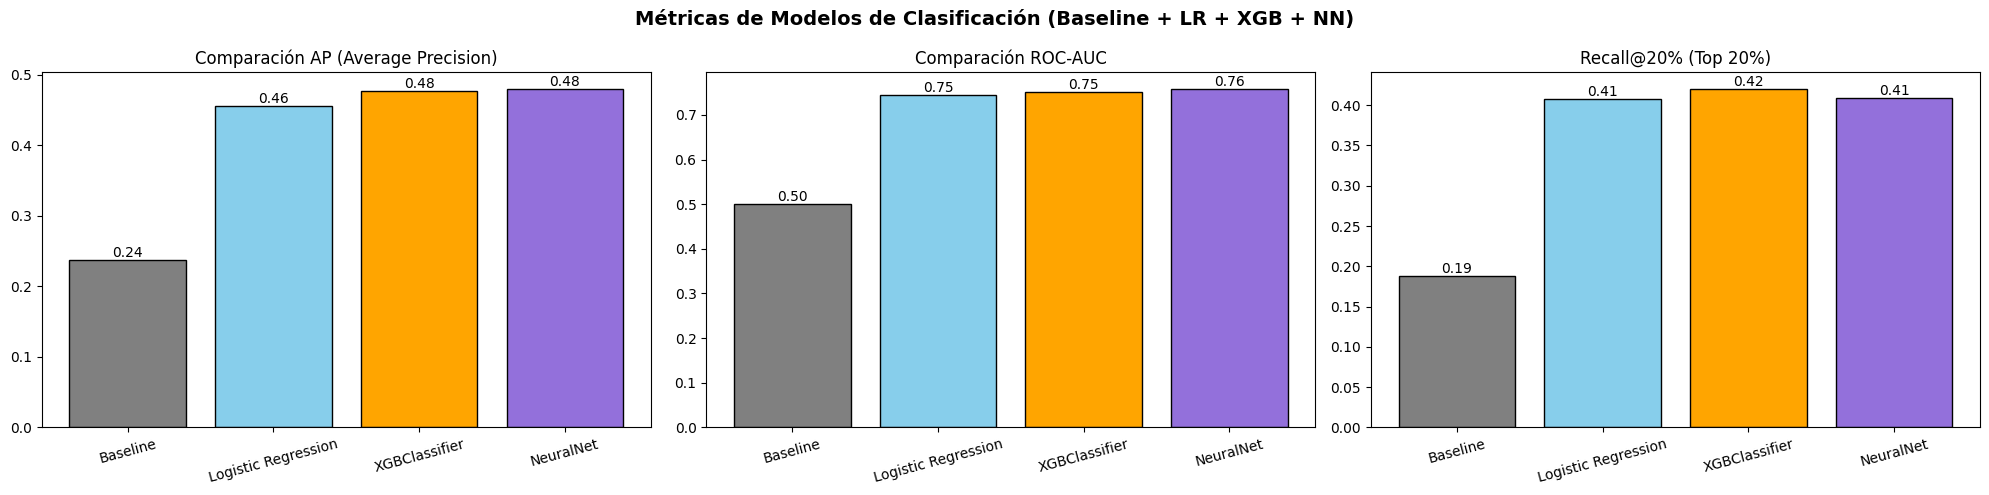

In [ ]:
# ============================================================
# MODELADO (SPLIT FINAL - HOLDOUT TEST): CLASIFICACIÓN (Predicción de long-stay)
# ============================================================
# Se prueban distintos algoritmos de clasificación:
# - Regresión logística (con GridSearchCV)
# - XGBoost Classifier
# ============================================================

# ------------------------------------------------------------
# 1) Definición de target binario
# ------------------------------------------------------------

y_train_bin = df_train[TARGET_BIN]
y_test_bin = df_test[TARGET_BIN]

# ------------------------------------------------------------
# 2) Logistic Regression con GridSearchCV
# ------------------------------------------------------------

logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

param_lr = {
    "model__C": [0.1, 1.0, 3.0],
    "model__penalty": ["l2"]
}

gs_lr = GridSearchCV(logreg, param_lr, scoring="average_precision",
                     cv=kf.split(X_train, y_train_bin, groups=groups), n_jobs=-1)
gs_lr.fit(X_train, y_train_bin)

# ==========================
#  Entrenamiento unificado: LR (best), XGB y NN + gráfico único
# ==========================

# --- 1) Definir/asegurar to_dense y densifier para NN (si no existen) ---
try:
    densifier  # si ya existe, no redefinimos
except NameError:
    from sklearn.preprocessing import FunctionTransformer
    def to_dense(X):
        return X.toarray() if hasattr(X, "toarray") else X
    densifier = FunctionTransformer(to_dense, feature_names_out="one-to-one")

# --- 2) Definir wrapper Keras para clasificación (si no existe) ---
try:
    KerasClassifierSK
except NameError:
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras import layers, regularizers, callbacks, optimizers
    from sklearn.base import BaseEstimator, ClassifierMixin
    from sklearn.utils.class_weight import compute_class_weight

    tf.keras.utils.set_random_seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)

    def build_cls_model(input_dim, hidden_units=64, hidden_layers=2, dropout=0.10, l2=1e-4, lr=1e-3):
        inp = tf.keras.Input(shape=(input_dim,), name="features")
        x = inp
        for i in range(hidden_layers):
            x = layers.Dense(
                hidden_units, activation="relu",
                kernel_regularizer=regularizers.l2(l2),
                name=f"dense_{i+1}"
            )(x)
            if dropout and dropout > 0:
                x = layers.Dropout(dropout, name=f"dropout_{i+1}")(x)
        out = layers.Dense(1, activation="sigmoid", name="p")(x)
        model = tf.keras.Model(inp, out, name="nn_classifier")
        model.compile(
            optimizer=optimizers.Adam(learning_rate=lr),
            loss="binary_crossentropy",
            metrics=[tf.keras.metrics.AUC(name="auc"),
                     tf.keras.metrics.AUC(name="pr_auc", curve="PR")]
        )
        return model

    class KerasClassifierSK(BaseEstimator, ClassifierMixin):
        def __init__(self, hidden_units=64, hidden_layers=2, dropout=0.10, l2=1e-4,
                     lr=1e-3, epochs=60, batch_size=256, validation_split=0.1,
                     patience_es=8, patience_rlr=4, verbose=0, random_state=None,
                     use_class_weight=True):
            self.hidden_units = hidden_units
            self.hidden_layers = hidden_layers
            self.dropout = dropout
            self.l2 = l2
            self.lr = lr
            self.epochs = epochs
            self.batch_size = batch_size
            self.validation_split = validation_split
            self.patience_es = patience_es
            self.patience_rlr = patience_rlr
            self.verbose = verbose
            self.random_state = random_state
            self.use_class_weight = use_class_weight
            self.model_ = None
            self.input_dim_ = None
            self.class_weight_ = None

        def fit(self, X, y):
            X = np.asarray(X, dtype=np.float32)
            y = np.asarray(y, dtype=np.float32).reshape(-1, 1)

            if self.random_state is not None:
                tf.keras.utils.set_random_seed(self.random_state)
                np.random.seed(self.random_state)

            input_dim = X.shape[1]
            if (self.model_ is None) or (self.input_dim_ != input_dim):
                self.model_ = build_cls_model(
                    input_dim=input_dim,
                    hidden_units=self.hidden_units,
                    hidden_layers=self.hidden_layers,
                    dropout=self.dropout,
                    l2=self.l2,
                    lr=self.lr
                )
                self.input_dim_ = input_dim

            cw = None
            if self.use_class_weight:
                y_flat = y.ravel().astype(int)
                classes = np.unique(y_flat)
                weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_flat)
                cw = {int(c): float(w) for c, w in zip(classes, weights)}
                self.class_weight_ = cw

            es  = callbacks.EarlyStopping(monitor="val_loss", patience=self.patience_es, restore_best_weights=True)
            rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=self.patience_rlr, min_lr=1e-5)

            self.model_.fit(
                X, y,
                epochs=self.epochs,
                batch_size=self.batch_size,
                validation_split=self.validation_split,
                class_weight=cw,
                callbacks=[es, rlr],
                verbose=self.verbose
            )
            return self

        def predict_proba(self, X):
            X = np.asarray(X, dtype=np.float32)
            p1 = self.model_.predict(X, verbose=0).ravel()
            p0 = 1.0 - p1
            return np.vstack([p0, p1]).T

        def predict(self, X):
            return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# --- 3) Definir pipelines de modelos (sin entrenar aún) ---
#     Nota: usamos el mejor estimador de LR ya obtenido por GridSearchCV arriba.
xgb_cls = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        random_state=RANDOM_STATE, n_estimators=150, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, max_depth=4, reg_lambda=1.0,
        eval_metric="logloss"
    ))
])

nn_cls = Pipeline(steps=[
    ("preprocess", preprocess),
    ("to_dense", densifier),
    ("model", KerasClassifierSK(
        random_state=RANDOM_STATE,
        epochs=60, batch_size=256, validation_split=0.1,
        hidden_units=64, hidden_layers=2, dropout=0.10, l2=1e-4, lr=1e-3,
        use_class_weight=True, verbose=0
    ))
])

# --- 4) Registro de modelos (sin baseline acá) ---
models_cls = {
    "Logistic Regression": gs_lr.best_estimator_,
    "XGBClassifier":       xgb_cls,
    "NeuralNet":           nn_cls
}

# --- 5) Función de evaluación (si no la tenés ya definida arriba) ---
def eval_classifier(pipeline, X_te, y_te):
    proba = pipeline.predict_proba(X_te)[:, 1]
    ap = average_precision_score(y_te, proba)
    roc = roc_auc_score(y_te, proba)
    k = max(1, int(0.2 * len(y_te)))
    rec_at_20 = float(recall_at_topk(y_te, proba, k))
    return {"ap": float(ap), "roc_auc": float(roc), "recall_at_20": rec_at_20}, proba

# --- 6) Entrenar y evaluar todos los modelos y graficar una sola vez ---
cls_metrics = {}
cls_probas  = {}

for name, pipe in models_cls.items():
    pipe.fit(X_train, y_train_bin)
    cls_metrics[name], cls_probas[name] = eval_classifier(pipe, X_test, y_test_bin)
    print(f"{name} (test):", cls_metrics[name])

# Consolidar con baseline (asumiendo base_cls_metrics ya calculado)
all_cls_metrics = {"Baseline": base_cls_metrics, **cls_metrics}

# --- 7) Gráfico único ---

# Definimos orden deseado para CLASIFICACIÓN y colores propios
desired_order = ["Baseline", "Logistic Regression", "XGBClassifier", "NeuralNet"]
labels_cls = [l for l in desired_order if l in all_cls_metrics]

color_map = {
    "Baseline": "gray",
    "Logistic Regression": "skyblue",
    "XGBClassifier": "orange",
    "NeuralNet": "mediumpurple",
}

x = np.arange(len(labels_cls))

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# AP
ap_values = [all_cls_metrics[l]["ap"] for l in labels_cls]
axes[0].bar(x, ap_values, color=[color_map[l] for l in labels_cls], edgecolor="black")
axes[0].set_title("Comparación AP (Average Precision)")
for i, v in enumerate(ap_values):
    axes[0].text(x[i], v, f"{v:.2f}", ha="center", va="bottom")
axes[0].set_xticks(x); axes[0].set_xticklabels(labels_cls, rotation=15)

# ROC-AUC
roc_values = [all_cls_metrics[l]["roc_auc"] for l in labels_cls]
axes[1].bar(x, roc_values, color=[color_map[l] for l in labels_cls], edgecolor="black")
axes[1].set_title("Comparación ROC-AUC")
for i, v in enumerate(roc_values):
    axes[1].text(x[i], v, f"{v:.2f}", ha="center", va="bottom")
axes[1].set_xticks(x); axes[1].set_xticklabels(labels_cls, rotation=15)

# Recall@20%
rec_values = [all_cls_metrics[l]["recall_at_20"] for l in labels_cls]
axes[2].bar(x, rec_values, color=[color_map[l] for l in labels_cls], edgecolor="black")
axes[2].set_title("Recall@20% (Top 20%)")
for i, v in enumerate(rec_values):
    axes[2].text(x[i], v, f"{v:.2f}", ha="center", va="bottom")
axes[2].set_xticks(x); axes[2].set_xticklabels(labels_cls, rotation=15)

plt.suptitle("Métricas de Modelos de Clasificación (Baseline + LR + XGB + NN)",
             fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


Mejor clasificador según AP: NeuralNet → AP=0.480


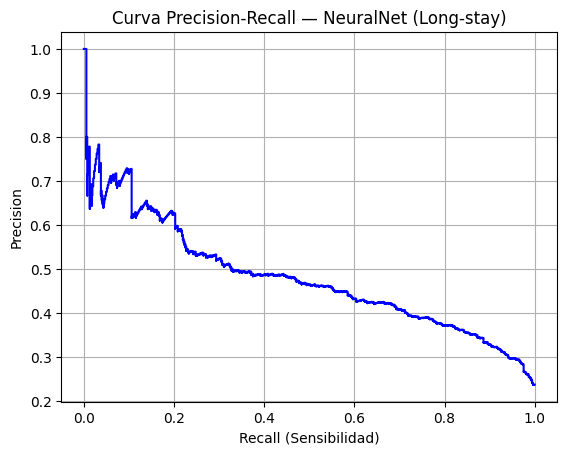

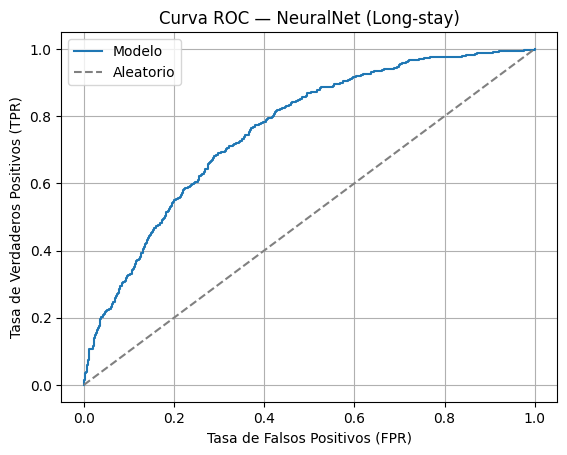


Comparación Regresión:


,mae,rmse,mape
Baseline Reg,2.452915,3.147780,66.666538
ElasticNet,2.117532,2.745289,59.421215
XGBRegressor,2.098384,2.698003,58.745455
LGBMRegressor,2.061047,2.677342,56.380429
NeuralNet,2.065409,2.709032,55.647380



Comparación Clasificación:


,ap,roc_auc,recall_at_20
Baseline,0.236771,0.500000,0.187500
Logistic Regression,0.455398,0.745069,0.407197
XGBClassifier,0.477050,0.750922,0.420455
NeuralNet,0.479962,0.758533,0.409091


In [ ]:
# ============================================================
# SELECCIÓN DE MODELO Y GRÁFICAS (Clasificación Long-stay)
# ============================================================

# Función para curva Precision-Recall
def plot_pr(y_true, scores, title):
    precision, recall, _ = precision_recall_curve(y_true, scores)
    plt.figure()
    plt.step(recall, precision, where='post', color="blue")
    plt.xlabel("Recall (Sensibilidad)")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Función para curva ROC
def plot_roc(y_true, scores, title):
    fpr, tpr, _ = roc_curve(y_true, scores)
    plt.figure()
    plt.plot(fpr, tpr, label="Modelo")
    plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Aleatorio")
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------------------------------------------
# 1) Selección automática del mejor clasificador (incluye NN)
# ------------------------------------------------------------
from sklearn.metrics import precision_recall_curve, roc_curve

# Construimos métricas y probabilidades con TODOS los modelos disponibles.
# Soporta dos estilos:
#  - Estilo "loop unificado": cls_metrics / cls_probas (diccionarios ya listos)
#  - Estilo "variables sueltas": lr_metrics/lr_proba, xgb_cls_metrics/xgb_proba, nn_cls_metrics/nn_proba

all_cls_metrics = {}
all_cls_probas  = {}

if 'cls_metrics' in globals() and 'cls_probas' in globals():
    # Estilo loop unificado
    all_cls_metrics.update(cls_metrics)
    all_cls_probas.update(cls_probas)
else:
    # Estilo variables sueltas
    if 'lr_metrics' in globals():       all_cls_metrics['Logistic Regression'] = lr_metrics
    if 'xgb_cls_metrics' in globals():  all_cls_metrics['XGBClassifier']       = xgb_cls_metrics
    if 'nn_cls_metrics' in globals():   all_cls_metrics['NeuralNet']           = nn_cls_metrics

    if 'lr_proba' in globals():         all_cls_probas['Logistic Regression']  = lr_proba
    if 'xgb_proba' in globals():        all_cls_probas['XGBClassifier']        = xgb_proba
    if 'nn_proba' in globals():         all_cls_probas['NeuralNet']            = nn_proba

# Agregamos Baseline (solo a métricas, no lo consideramos para "mejor")
if 'base_cls_metrics' in globals():
    all_cls_metrics = {'Baseline': base_cls_metrics, **all_cls_metrics}

# Verificación mínima
if len(all_cls_metrics) == 0:
    raise RuntimeError("No hay métricas de clasificación disponibles. Verifica el entrenamiento previo.")

# Candidatos para 'mejor' (excluye Baseline)
candidates = {name: m for name, m in all_cls_metrics.items() if name.lower() != 'baseline'}
if len(candidates) == 0:
    raise RuntimeError("No hay modelos candidatos (no baseline) para seleccionar el mejor.")

best_model_name = max(candidates, key=lambda m: candidates[m]['ap'])
if best_model_name not in all_cls_probas:
    raise RuntimeError(f"No se encontraron probabilidades para {best_model_name}. ¿Olvidaste guardar *_proba?")
best_proba = all_cls_probas[best_model_name]

print(f"Mejor clasificador según AP: {best_model_name} → AP={candidates[best_model_name]['ap']:.3f}")

# Curvas para el mejor clasificador
plot_pr(y_test_bin, best_proba, f"Curva Precision-Recall — {best_model_name} (Long-stay)")
plot_roc(y_test_bin, best_proba, f"Curva ROC — {best_model_name} (Long-stay)")

# ------------------------------------------------------------
# 2) Tablas comparativas (Regresión y Clasificación)
# ------------------------------------------------------------
# Compilamos comparaciones conservando un orden deseado y tolerando ausencias.
def _maybe(d, key, fallback=None):
    return d.get(key, fallback if fallback is not None else {})

# --- REGRESIÓN ---
if 'metrics_dict' in globals() and isinstance(metrics_dict, dict) and ("NeuralNet" in metrics_dict or len(metrics_dict) > 0):
    comp_reg = {"Baseline Reg": base_reg_metrics, **metrics_dict}

# Fallback (variables sueltas + gbm_results si lo usaste antes)
else:
    comp_reg = {
        "Baseline Reg": locals().get('base_reg_metrics', {}),
        "ElasticNet":   locals().get('enet_metrics', {}),
        "XGBRegressor": (locals().get('xgb_reg_metrics', {})
                         or (gbm_results.get("xgb", {}) if 'gbm_results' in globals() else {})),
        "LGBMRegressor":(locals().get('lgb_reg_metrics', {})
                         or (gbm_results.get("lgbm", {}) if 'gbm_results' in globals() else {})),
        "NeuralNet":    locals().get('nn_reg_metrics', {})   # por si guardaste la NN suelta
    }

print("\nComparación Regresión:")
display(pd.DataFrame(comp_reg).T)

# --- CLASIFICACIÓN ---
# Orden deseado incluyendo TODOS los modelos usados
desired_order_cls = ["Baseline", "Logistic Regression", "XGBClassifier", "NeuralNet"]
comp_cls = {name: all_cls_metrics[name] for name in desired_order_cls if name in all_cls_metrics}

print("\nComparación Clasificación:")
display(pd.DataFrame(comp_cls).T)
